# Meta RL Experiments with Garage

We use the [garage library](https://github.com/rlworkgroup/garage) to evaluate some of the popular meta RL algorithms on our problems. IN particular we test *MAML-TPRO*, *RL$^2$* and *PEARL*.


## Installation

Start by installing the garage package [as advised on their docs](https://garage.readthedocs.io/en/latest/user/installation.html). Note that as garage is not longer very actively maintained, installing it can be a bit tricky. Here are some tips for debugging:

1. Use Python 3.7 -> anything above has thrown errors for us about packages not resolving.
2. Really ensure that mujoco is installed correctly (and on the correct path, although this is needed only for testing installation).
3. You may need to install patchelf [as described here](https://github.com/openai/mujoco-py/issues/652>).


## Garage experiments

Next, we run the actual experiments using the experiment scripts provided in `bauwerk/baselines`. Assuming this notebook is run out of its directory in the repo, you can run the experiment using:

In [1]:
import matplotlib.pyplot as plt
import os

# Setup and helper code
import bauwerk
import bauwerk.eval
import bauwerk.benchmarks
import gym
import numpy as np

# The length of each task, i.e. how long we aim to 
TASK_LEN = 24*30 # evaluate on 1 month of actions

In [2]:
# Load experiment data

from tensorboard.backend.event_processing import event_accumulator

distb_maml_path = os.path.expanduser("~/bauwerk/baselines/data/local/experiment/maml_trpo_bauwerk_build_dist_b_seed=1_epochs=300_episode_len=168_steps_per_task=720_meta_batch_size=20_1/events.out.tfevents.1675679542.dev-gpu-beobench.cl.cam.ac.uk")
distb_maml_ea = event_accumulator.EventAccumulator(distb_maml_path)
distb_maml_ea.Reload()

2023-02-06 14:38:23.694223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 14:38:24.698289: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/af691/.mujoco/mujoco210/bin
2023-02-06 14:38:24.698418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/af691/.mujoco/mujoco210/bin
2023-02-06 14:38:24.698428: W tensorflow/compiler/tf2tensorr

In [3]:


# Create SolarBatteryHouse environment
build_dist_b = bauwerk.benchmarks.BuildDistB(seed=0, episode_len=TASK_LEN)
test_env = build_dist_b.make_env()

battery_sizes = [1,5,15,25]
env_data = {}

for size in battery_sizes:
    env_data[size] = {}
    task = bauwerk.benchmarks.Task(
        cfg=bauwerk.envs.solar_battery_house.EnvConfig(
            battery_size=size, 
            episode_len=TASK_LEN
        )
    )
    test_env.set_task(task)
    env_data[size]["optimal"] = bauwerk.eval.get_optimal_perf(test_env, eval_len=TASK_LEN)
    env_data[size]["no charge"] = bauwerk.eval.evaluate_actions(np.zeros((TASK_LEN,1)), test_env)
    env_data[size]["random"], _ = bauwerk.eval.get_avg_rndm_perf(
        test_env, 
        eval_len=TASK_LEN,
        num_samples=10,
    )

    def get_feasible_val(perc):
        return env_data[size]["optimal"] * perc + env_data[size]["no charge"] * (1 - perc)


    env_data[size]["PEARL"] = get_feasible_val(0.9)
    env_data[size]["RL$^2$"] = get_feasible_val(0.5)
    # get final value of maml experiment
    env_data[size]["MAML-TPRO"] = distb_maml_ea.Scalars(f"MetaTest/bauwerk/House-{size}kWh/AverageReturn")[-1].value / TASK_LEN
    

In [4]:
env_data[1]["MAML-TPRO"], env_data[1]["RL$^2$"]

(-0.21502825419108074, -0.22998590616515796)

In [5]:
# relevant tutorial https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

import copy
import seaborn as sns
sns.set_theme(style="white", context="paper", font="serif")
palette = sns.color_palette("deep")

num_values_per_house = 4
space_between_houses = 2.5
height = 1/(num_values_per_house + space_between_houses)


def get_rel_perf(maximum, minimum, perf):
    return (perf-minimum)/(maximum-minimum)

def get_loc(house, idx):
    """Get location of bar in plot for perf measure 'idx' in building 'house'."""
    return house - height*(num_values_per_house/2 - 0.5) + height * idx



def create_bar_chart(env_data, max_key="optimal", min_key="random", remove_keys=None, include_legend=True):
    # Figure Size
    fig, ax = plt.subplots(figsize =(4.5, 4.5))

    ys = []
    y_labels = []
    nocharge_lines = []

    # Create consistent color code for each method
    col_code = {}
    for i, key in enumerate(env_data[1].keys()):
        col_code[key] = i

    for i, size in enumerate(env_data.keys()):
        name = f"{size}kWh"
        rel_nocharge_perf = get_rel_perf(
            maximum = env_data[size][max_key],
            minimum = env_data[size][min_key], 
            perf = env_data[size]["no charge"]
        )

        perf_dict: dict = copy.deepcopy(env_data[size])
        perf_dict.pop(max_key)
        perf_dict.pop(min_key)

        if remove_keys is not None:
            for key in remove_keys:
                perf_dict.pop(key)
        
        for j, (key, value) in enumerate(perf_dict.items()):
            rel_value = get_rel_perf(
                maximum = env_data[size][max_key],
                minimum = env_data[size][min_key], 
                perf = env_data[size][key]
            )
            ax.barh(get_loc(i,j) , width=rel_value, height=height, color=palette[col_code[key]], label=key)

        ys.append(i)
        y_labels.append(name)
        



    # Add annotation to bars
    x_len = ax.get_xbound()[1] - ax.get_xbound()[0]
    for i in ax.patches:
        width = i.get_width()
        plt.text(width + x_len * 0.007 * np.sign(width), i.get_y()+ i.get_height()*0.55,
                str(round((width), 3)),
                fontsize = 8, #fontweight ='bold',
                color = 'black',
                horizontalalignment=("left" if width>0 else "right"),
                verticalalignment="center",
                #transform=ax.transAxes
                )

    # add the battery size labels
    ax.set_yticks(ys, y_labels)
    ax.set_xticks([0,1], [f"0\n ({min_key})", f"1\n ({max_key})"])
    ax.tick_params(axis="x", pad=-10) # reduce the padding of tick labels

    # add axis labels
    ax.set_xlabel(f"Performance relative to {min_key} and {max_key} ")
    ax.set_ylabel("Battery size")

    if include_legend:
        # avoid duplicate labels
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(),loc="lower left")

    # change order to from smallest to largest battery size
    ax.invert_yaxis()
    ax.set_title("Building distribution B performance (PLACEHOLDER, not real data)")

    # remove top/bottom lines
    ax.vlines([0,1],*ax.get_ylim(),colors=["grey","grey"], linestyles=["solid","dotted"])

    # remove default frame around figure
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # extend figure slightly to left to show full vline at 0
    ax.set_xlim(left=ax.get_xlim()[0] - 0.005)

    plt.tight_layout()
    plt.savefig("test.png", dpi=300)
    plt.show()

In [6]:
def create_bar_chart_absolute(env_data, remove_keys=None, include_legend=True):
    # Figure Size
    fig, ax = plt.subplots(figsize =(4.5, 4.5))

    ys = []
    y_labels = []
    nocharge_lines = []

    # Create consistent color code for each method
    col_code = {}
    for i, key in enumerate(env_data[1].keys()):
        col_code[key] = i

    for i, size in enumerate(env_data.keys()):
        name = f"{size}kWh"

        perf_dict: dict = copy.deepcopy(env_data[size])

        if remove_keys is not None:
            for key in remove_keys:
                perf_dict.pop(key)
        
        for j, (key, value) in enumerate(perf_dict.items()):
            ax.barh(get_loc(i,j) , width=value, height=height, color=palette[col_code[key]], label=key)

        ys.append(i)
        y_labels.append(name)
        



    # Add annotation to bars
    x_len = ax.get_xbound()[1] - ax.get_xbound()[0]
    for i in ax.patches:
        width = i.get_width()
        plt.text(width + x_len * 0.007 * np.sign(width), i.get_y()+ i.get_height()*0.55,
                str(round((width), 3)),
                fontsize = 8, #fontweight ='bold',
                color = 'black',
                horizontalalignment=("left" if width>0 else "right"),
                verticalalignment="center",
                #transform=ax.transAxes
                )

    # add the battery size labels
    ax.set_yticks(ys, y_labels)
    #ax.tick_params(axis="x", pad=-10) # reduce the padding of tick labels

    # add axis labels
    ax.set_xlabel(f"Absolute performance (price paid per timestep)")
    ax.set_ylabel("Battery size")

    if include_legend:
        # avoid duplicate labels
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(),loc="lower left")

    # change order to from smallest to largest battery size
    ax.invert_yaxis()
    ax.set_title("Building distribution B performance (PLACEHOLDER, not real data)")

    # remove top/bottom lines
    #ax.vlines([0,1],*ax.get_ylim(),colors=["grey","grey"], linestyles=["solid","dotted"])

    # remove default frame around figure
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # extend figure slightly to left to show full vline at 0
    ax.set_xlim(left=ax.get_xlim()[0] - 0.005)

    plt.tight_layout()
    plt.savefig("test.png", dpi=300)
    plt.show()

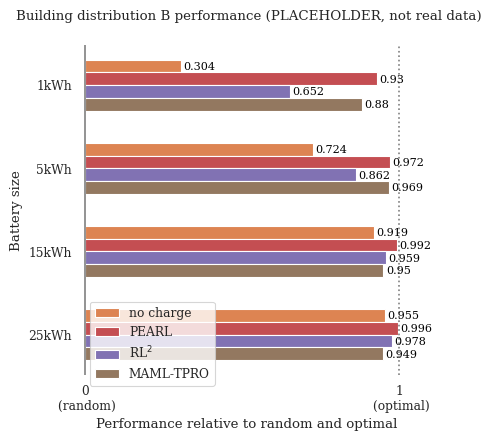

In [7]:
create_bar_chart(env_data, "optimal","random")

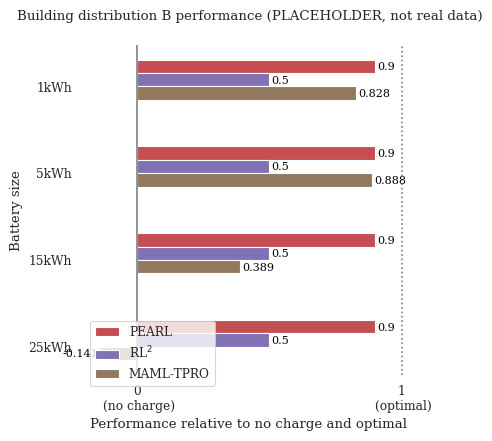

In [8]:
create_bar_chart(env_data, "optimal","no charge", remove_keys=["random"]) #include_legend=False)

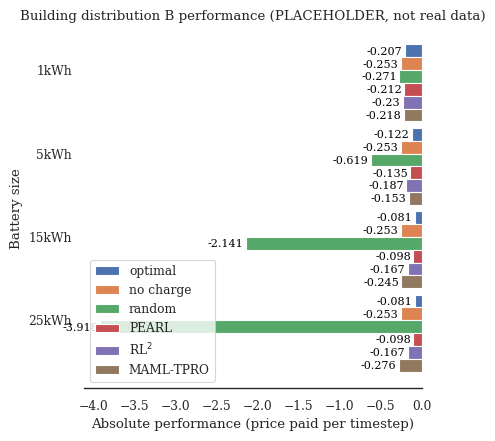

In [34]:
create_bar_chart_absolute(env_data=env_data)

In [100]:
env_data[1]["MAML-TPRO"]*24*30

-153.57579040527344

In [2]:
from tensorboard.backend.event_processing import event_accumulator

tb_path = "/home/af691/bauwerk/baselines/data/local/experiment/maml_trpo_bauwerk_build_dist_b_seed=1_epochs=300_episode_len=168_steps_per_task=720_meta_batch_size=20_1/events.out.tfevents.1675679542.dev-gpu-beobench.cl.cam.ac.uk"
ea = event_accumulator.EventAccumulator(tb_path)

In [85]:
ea.Reload()
ea.Tags()

ea.Scalars("MetaTest/bauwerk/House-1kWh/AverageReturn")


[ScalarEvent(wall_time=1675679658.286204, step=115200, value=-197.9077911376953),
 ScalarEvent(wall_time=1675679761.6910305, step=230400, value=-201.0448455810547),
 ScalarEvent(wall_time=1675679859.4848597, step=345600, value=-195.40599060058594),
 ScalarEvent(wall_time=1675679957.7742357, step=460800, value=-192.14935302734375),
 ScalarEvent(wall_time=1675680058.5409875, step=576000, value=-192.44044494628906),
 ScalarEvent(wall_time=1675680258.1395288, step=806400, value=-182.74237060546875),
 ScalarEvent(wall_time=1675680359.4950562, step=921600, value=-187.59034729003906),
 ScalarEvent(wall_time=1675680458.958781, step=1036800, value=-184.58560180664062),
 ScalarEvent(wall_time=1675680558.718695, step=1152000, value=-178.39833068847656),
 ScalarEvent(wall_time=1675680660.9425821, step=1267200, value=-178.66598510742188),
 ScalarEvent(wall_time=1675680861.032345, step=1497600, value=-173.73760986328125),
 ScalarEvent(wall_time=1675680963.43816, step=1612800, value=-169.095855712890